In [7]:
# make sure to run this on virtual env with python 3.8.20
! pip install pandas scikit-learn torch essentia matplotlib umap-learn plotly nbformat


In [8]:
import os, json, csv, numpy as np, pandas as pd, torch
import torch.nn.functional as F
import essentia.standard as es
import ast
from typing import List 


def read_csv_safe(path: str, columns: List[str]) -> pd.DataFrame:

    if not os.path.exists(path) or os.path.getsize(path) == 0:
        return pd.DataFrame(columns=columns)

    try:
        df = pd.read_csv(path)
        # If header exists but no rows: make sure columns are present
        missing = [c for c in columns if c not in df.columns]
        if missing:
            df = pd.DataFrame(columns=columns)  # bad header -> reset
        return df
    except pd.errors.EmptyDataError:
        return pd.DataFrame(columns=columns)

# ──────────────────────────────────────────────────────────────────
# 1) helper to append a (artist, song, vector) row safely
# ──────────────────────────────────────────────────────────────────
def append_vec(csv_path, artist, song, vec):
    df = read_csv_safe(csv_path, ["artist", "song", "vector"])

    mask = (df["artist"] == artist) & (df["song"] == song)
    if not mask.any():                      # only add if not present
        df = pd.concat([df,
                        pd.DataFrame([{"artist": artist,
                                       "song"  : song,
                                       "vector": vec}])],
                       ignore_index=True)

    # <- key fix: quote every string column so embedded commas are safe
    df.to_csv(csv_path, index=False, quoting=csv.QUOTE_NONNUMERIC)

# ──────────────────────────────────────────────────────────────────
# 2)   feature-extraction helpers (unchanged logic)
# ──────────────────────────────────────────────────────────────────
def extract_features(artist, song_name, audio_folder="audio"):
    wav = os.path.join(audio_folder, f"{artist} - {song_name}.wav")
    jsv = os.path.join("song_features", f"{artist} - {song_name}.json")
    feats, _ = es.MusicExtractor(lowlevelStats=['mean','stdev'],
                                 rhythmStats =['mean','stdev'],
                                 tonalStats  =['mean','stdev'])(wav)
    es.YamlOutput(filename=jsv, format='json')(feats)
    return jsv

def select_features(js_file, artist, song):
    with open(js_file) as f:
        d = json.load(f)
    feats = [
        d["lowlevel"]["average_loudness"],
        d["lowlevel"]["dissonance"]["mean"],
        d["lowlevel"]["dynamic_complexity"],
        d["lowlevel"]["spectral_centroid"]["mean"],
        d["lowlevel"]["spectral_flux"]["mean"],
        d["lowlevel"]["spectral_entropy"]["mean"],
        d["lowlevel"]["spectral_rolloff"]["mean"],
        d["lowlevel"]["hfc"]["mean"],
        d["lowlevel"]["pitch_salience"]["mean"],
        d["lowlevel"]["spectral_complexity"]["mean"],
        d["lowlevel"]["spectral_spread"]["mean"],
        d["lowlevel"]["spectral_strongpeak"]["mean"],
        *d["lowlevel"]["barkbands"]["mean"],
        *d["lowlevel"]["mfcc"]["mean"],
        *d["lowlevel"]["gfcc"]["mean"],
        d["rhythm"]["bpm"],
        d["rhythm"]["danceability"],
        d["rhythm"]["onset_rate"],
        d["tonal"]["chords_strength"]["mean"],
        d["tonal"]["hpcp_crest"]["mean"],
        d["tonal"]["hpcp_entropy"]["mean"],
        d["tonal"]["key_krumhansl"]["strength"],
    ]
    append_vec("raw_vectors.csv", artist, song, feats)

# ──────────────────────────────────────────────────────────────────
# 3)  wrapper that loops through the CSV list (no parallelism)
# ──────────────────────────────────────────────────────────────────
def mass_extract_slow(csv_file):
    df = pd.read_csv(csv_file)
    need = {"shortcode", "music_artist", "music_title"}
    if not need.issubset(df.columns):
        raise ValueError(f"CSV must contain {need}")

    df = (df[df.music_artist.notna() & df.music_title.notna()]
            .drop_duplicates("shortcode"))

    for idx, row in df.iterrows():
        artist = row["music_artist"].replace("'", "")
        title  = row["music_title"].replace("'", "")
        print(f"[{idx+1}/{len(df)}] {artist} – {title}")

        try:
            jsn = extract_features(artist, title)
            select_features(jsn, artist, title)
        except Exception as e:
            print("   failed:", e)

def encode_vec(artist, song_name, encoder,
               raw_csv="raw_vectors.csv",
               enc_csv="encoded_vectors.csv"):

    raw_df = read_csv_safe(raw_csv, ["artist", "song", "vector"])
    row    = raw_df[(raw_df.artist == artist) & (raw_df.song == song_name)]
    if row.empty:
        print(f"• skip {artist} – {song_name}  (raw vector missing)")
        return None                         # <-- important

    enc_df = read_csv_safe(enc_csv, ["artist", "song", "vector"])
    if ((enc_df.artist == artist) & (enc_df.song == song_name)).any():
        print(f"• skip {artist} – {song_name}  (already encoded)")
        vec128 = enc_df[(enc_df.artist == artist) &
                        (enc_df.song == song_name)].iloc[0]["vector"]
        return vec128                       # return stored list-string

    # ----- encode -----
    vec72  = np.array(ast.literal_eval(row.iloc[0]["vector"]), np.float32)
    vec72  = (vec72 - mean) / std
    with torch.no_grad():
        emb = encoder(torch.tensor(vec72).view(1, -1)).squeeze(0).numpy()

    append_vec(enc_csv, artist, song_name, emb.tolist())
    return emb.tolist()                     # return freshly created vector




# combine all steps to extract select and encode
# ------------------------------------------------------------------
# Fast-path wrapper:  extract only if raw vector missing
# ------------------------------------------------------------------
def extract_encode(artist: str, song_name: str, encoder=None,
                   raw_csv="raw_vectors.csv"):
    # --- 1. does the raw vector already exist? --------------------
    if os.path.exists(raw_csv):
        df = pd.read_csv(raw_csv)
        in_raw = ((df["artist"] == artist) & (df["song"] == song_name)).any()
    else:
        in_raw = False                 # file not there yet -> definitely missing

    # --- 2. run Essentia only when row is absent -----------------
    if not in_raw:
        print(f"  → extracting raw vector for {artist} – {song_name}")
        json_path = extract_features(artist, song_name)
        select_features(json_path, artist, song_name)
    else:
        print(f"  • skip raw extraction (already in csv)")

    # --- 3. optionally encode ------------------------------------
    if encoder is not None:
        encode_vec(artist, song_name, encoder)


# mass encode using extract and encode on a csv of many many pairs YATTA!!
def mass_encoder(csv_file, encoder):

    # load csv of pair data
    pair_data = pd.read_csv(csv_file)
    if not all(c in pair_data.columns
                for c in ["shortcode", "music_artist", "music_title"]):
        raise ValueError("CSV must contain 'shortcode', 'music_artist', 'music_title'.")
    pair_data = pair_data[pair_data["music_artist"].notna() & pair_data["music_title"].notna()]
    pair_data = pair_data.drop_duplicates(["shortcode"])

    # output file 
    output_file = os.path.join(os.path.dirname(csv_file), "rawr_dionsaur.csv")
    output_rows = []

    # iterate through each pair
    for idx, row in pair_data.iterrows():
        artist = row["music_artist"].replace("'", "")
        song_name  = row["music_title"].replace("'", "")
        shortcode = row["shortcode"]
        img_link  = row.get("head_image_url", "")

        print(f"Processing {idx+1}: {artist} - {song_name}")
        try:
            # extract and encode it
            extract_encode(artist, song_name, encoder)

            encoded_df = pd.read_csv("encoded_vectors.csv", names=["artist", "song", "vector"], header=False)
            encoded_row = encoded_df[(encoded_df["artist"] == artist) & (encoded_df["song"] == song_name)]
            embedding = encoded_row["vector"].values.flatten().tolist()

            # add to output shortcode, image, artist, title, and embedding
            output_rows.append({"shortcode": shortcode,
                                "link"     : img_link,
                                "artist"   : artist,
                                "title"    : song_name,
                                "embedding": embedding})

            pd.DataFrame(output_rows).to_csv(output_file, index=False)

        except Exception as e:
            print("   failed:", e)


def mass_encoder_encode_only(csv_file,
                             encoder,
                             out_encoded="encoded_vectors.csv",
                             out_report="rawr_dinosaur.csv"):

    df_pairs = pd.read_csv(csv_file)
    need = {"shortcode","music_artist","music_title"}
    if not need.issubset(df_pairs.columns):
        raise ValueError(f"CSV must contain {need}")

    df_pairs = (df_pairs[df_pairs.music_artist.notna() &
                         df_pairs.music_title.notna()]
                .drop_duplicates("shortcode"))

    # ← load (or create) the report file once
    report_df = read_csv_safe(out_report,
                              ["shortcode","link","artist","song","embedding"])
    processed = set(zip(report_df.artist, report_df.song))

    for idx,row in df_pairs.iterrows():
        artist = row["music_artist"].replace("'","")
        title  = row["music_title"].replace("'","")
        if (artist, title) in processed:
            print(f"[{idx+1}] {artist} – {title}  (already in report)")
            continue

        print(f"[{idx+1}] {artist} – {title}")
        try:
            vec128 = encode_vec(artist, title, encoder,
                                enc_csv=out_encoded)

            if vec128 is None:          # raw vector missing -> skip
                continue

            report_df = pd.concat([report_df, pd.DataFrame([{
                "shortcode": row["shortcode"],
                "link"     : row.get("head_image_url",""),
                "artist"   : artist,
                "song"     : title,
                "embedding": vec128
            }])], ignore_index=True)

            # write every iteration for crash-safety
            report_df.to_csv(out_report, index=False,
                             quoting=csv.QUOTE_NONNUMERIC)

        except Exception as e:
            print("   failed:", e)



In [ ]:
# import os, json, glob, numpy as np, pandas as pd, torch
# import torch.nn as nn
# import torch.nn.functional as F
# import essentia.standard as es
# from torch.utils.data import Dataset

# # ──────────────  PATHS for the two master sheets  ──────────────
# RAW_MASTER = "raw_vectors.csv"      # 72-dim vectors (song_csv)
# ENC_MASTER = "encoded_vectors.csv"  # 128-dim vectors (song_vector)

# # ────────────────────  small helper to keep masters  ───────────
# def _append_or_update(master_csv, artist, song, vec):
#     """Insert or update a single row in a master CSV file."""
#     if os.path.exists(master_csv):
#         df = pd.read_csv(master_csv)
#         mask = (df["artist"] == artist) & (df["song"] == song)
#         if mask.any():
#             df.loc[mask, "vector"] = [vec]      # update
#         else:
#             df = pd.concat([df, pd.DataFrame([{
#                 "artist": artist, "song": song, "vector": vec
#             }])], ignore_index=True)
#     else:
#         df = pd.DataFrame([{"artist": artist, "song": song, "vector": vec}])
#     df.to_csv(master_csv, index=False)

# # ────────────────────── feature-extraction helpers ─────────────
# def extract_features_from_json(json_file):
#     with open(json_file, "r") as f:
#         data = json.load(f)
#     features = [
#         data["lowlevel"]["average_loudness"],
#         data["lowlevel"]["dissonance"]["mean"],
#         data["lowlevel"]["dynamic_complexity"],
#         data["lowlevel"]["spectral_centroid"]["mean"],
#         data["lowlevel"]["spectral_flux"]["mean"],
#         data["lowlevel"]["spectral_entropy"]["mean"],
#         data["lowlevel"]["spectral_rolloff"]["mean"],
#         data["lowlevel"]["hfc"]["mean"],
#         data["lowlevel"]["pitch_salience"]["mean"],
#         data["lowlevel"]["spectral_complexity"]["mean"],
#         data["lowlevel"]["spectral_spread"]["mean"],
#         data["lowlevel"]["spectral_strongpeak"]["mean"],
#         *data["lowlevel"]["barkbands"]["mean"],
#         *data["lowlevel"]["mfcc"]["mean"],
#         *data["lowlevel"]["gfcc"]["mean"],
#         data["rhythm"]["bpm"],
#         data["rhythm"]["danceability"],
#         data["rhythm"]["onset_rate"],
#         data["tonal"]["chords_strength"]["mean"],
#         data["tonal"]["hpcp_crest"]["mean"],
#         data["tonal"]["hpcp_entropy"]["mean"],
#         data["tonal"]["key_krumhansl"]["strength"],
#     ]
#     return np.array(features)

# def save_vector_to_csv(vector, file_path,
#                        *, artist=None, song=None, master_csv=None):
#     """Save per-song CSV *and* optionally update a master sheet."""
#     pd.DataFrame([vector]).to_csv(file_path, index=False, header=False)
#     if master_csv and artist is not None:
#         _append_or_update(master_csv, artist, song, vector)

# def encode_and_save_song_vectors(csv_file, encoder,
#                                  *, artist=None, song=None):
#     df = pd.read_csv(csv_file, header=None)
#     vec = df.values.flatten().astype(np.float32)
#     with torch.no_grad():
#         emb = encoder(torch.tensor(vec).view(1, -1)).squeeze(0).numpy()
#     save_vector_to_csv(emb, csv_file,
#                        artist=artist, song=song, master_csv=ENC_MASTER)

# # ───────────────────  main per-song extraction  ─────────────────
# def extract_encode(artist, song_name,
#                    audio_folder="audio",
#                    json_folder="song_features",
#                    csv_folder="song_csv",
#                    encoder=None):
#     audio_f = os.path.join(audio_folder, f"{artist} - {song_name}.wav")
#     json_f  = os.path.join(json_folder,  f"{artist} - {song_name}.json")
#     csv_f   = os.path.join(csv_folder,   f"{artist} - {song_name}.csv")
#     raw_vec_f = os.path.join("song_vector", f"{artist} - {song_name}.csv")

#     features, _ = es.MusicExtractor(
#         lowlevelStats=['mean', 'stdev'],
#         rhythmStats =['mean', 'stdev'],
#         tonalStats  =['mean', 'stdev'])(audio_f)

#     es.YamlOutput(filename=json_f, format='json')(features)
#     vec = extract_features_from_json(json_f)

#     # save raw + update RAW_MASTER
#     save_vector_to_csv(vec, raw_vec_f,
#                        artist=artist, song=song_name, master_csv=RAW_MASTER)
#     save_vector_to_csv(vec, csv_f)                 # per-song copy for encoder

#     if encoder:
#         encode_and_save_song_vectors(csv_f, encoder,
#                                      artist=artist, song=song_name)

# # ───────────────────  mass batch processor  ────────────────────
# def mass_encoder(csv_file,
#                  audio_folder="audio",
#                  json_folder="song_features",
#                  csv_folder="song_csv",
#                  encoder=None):
#     pair_data = pd.read_csv(csv_file)
#     if not all(c in pair_data.columns
#                for c in ["shortcode", "music_artist", "music_title"]):
#         raise ValueError("CSV must contain 'shortcode', 'music_artist', 'music_title'.")
#     pair_data = pair_data[pair_data["music_artist"].notna()
#                           & pair_data["music_title"].notna()]

#     output_file = os.path.join(os.path.dirname(csv_file), "pairs_songencoded.csv")
#     output_rows = []

#     for idx, row in pair_data.iterrows():
#         artist = row["music_artist"].replace("'", "")
#         title  = row["music_title"].replace("'", "")
#         shortcode = row["shortcode"]
#         img_link  = row.get("head_image_url", "")

#         print(f"Processing {idx+1}: {artist} - {title}")
#         try:
#             extract_encode(artist, title,
#                            audio_folder=audio_folder,
#                            json_folder=json_folder,
#                            csv_folder=csv_folder,
#                            encoder=encoder)

#             enc_csv = os.path.join(csv_folder, f"{artist} - {title}.csv")
#             emb = pd.read_csv(enc_csv, header=None).values.flatten().tolist()
#             output_rows.append({"shortcode": shortcode,
#                                 "link"     : img_link,
#                                 "embedding": emb})
#             pd.DataFrame(output_rows).to_csv(output_file, index=False)
#         except Exception as e:
#             print("   failed:", e)


In [ ]:
# import os, glob, numpy as np, pandas as pd, torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader

# # ───────────────────────────  1.  ENCODER  ────────────────────────────
# class SongEncoder(nn.Module):
#     def __init__(self, input_dim=72, hidden_dim=256, bottleneck=128, dropout=0.1):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.GELU(),
#             nn.LayerNorm(hidden_dim),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.GELU(),
#             nn.LayerNorm(hidden_dim),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, bottleneck)
#         )

#     def forward(self, x):
#         x = x.view(x.size(0), -1)          # (B,72)
#         x = self.net(x)
#         return F.normalize(x, p=2, dim=1)  # unit‑norm

# # ────────────────────────  2.  AUTOENCODER  ───────────────────────────
# class SongAutoencoder(nn.Module):
#     def __init__(self, input_dim=72, hidden_dim=256, bottleneck=128):
#         super().__init__()
#         self.encoder = SongEncoder(input_dim, hidden_dim, bottleneck)
#         self.decoder = nn.Sequential(
#             nn.Linear(bottleneck, hidden_dim),
#             nn.GELU(),
#             nn.LayerNorm(hidden_dim),
#             nn.Linear(hidden_dim, input_dim)
#         )
#     def forward(self, x):
#         z = self.encoder(x)
#         return self.decoder(z)

# # ─────────────────────────  3.  DATASET  ──────────────────────────────
# class SongFeatureDataset(Dataset):
#     """
#     Loads every 72‑dim CSV in vector_dir, performs global z‑score normalisation
#     and stores mean/std for future inference.
#     """
#     def __init__(self, vector_dir="song_vector"):
#         self.vector_dir = vector_dir
#         self.files = sorted(glob.glob(os.path.join(vector_dir, "*.csv")))
#         if not self.files:
#             raise RuntimeError(f"No CSV files found in {vector_dir}")
#         self.data = np.stack([
#             pd.read_csv(f, header=None).values.flatten().astype(np.float32)
#             for f in self.files
#         ])
#         # global z‑score
#         self.mean = self.data.mean(0, keepdims=True)
#         self.std  = self.data.std(0,  keepdims=True) + 1e-8
#         np.save(os.path.join(vector_dir, "_mean_std.npy"),
#                 np.array([self.mean, self.std], dtype=object))
#         self.data = (self.data - self.mean) / self.std

#     def __len__(self):  return len(self.data)
#     def __getitem__(self, idx):
#         return torch.tensor(self.data[idx])

# def load_vector_normaliser(vector_dir="song_vector"):
#     """Load mean/std for inference normalisation"""
#     mean, std = np.load(os.path.join(vector_dir, "_mean_std.npy"), allow_pickle=True)
#     return mean.squeeze(), std.squeeze()

# # ───────────────────────  4.  TRAIN FUNCTION  ─────────────────────────
# def train_autoencoder(
#         vector_dir="song_vector",
#         out_dir   ="models",
#         epochs    =100,
#         batch     =64,
#         lr        =1e-3,
#         hidden    =256,
#         bottleneck=128,
#         device    ="cuda" if torch.cuda.is_available() else "cpu"):

#     os.makedirs(out_dir, exist_ok=True)
#     ds = SongFeatureDataset(vector_dir)
#     dl = DataLoader(ds, batch_size=batch, shuffle=True)

#     model = SongAutoencoder(72, hidden, bottleneck).to(device)
#     opt   = torch.optim.Adam(model.parameters(), lr=lr)
#     crit  = nn.MSELoss()
#     best  = 1e9

#     for ep in range(1, epochs+1):
#         tot = 0.0
#         for batch_x in dl:
#             batch_x = batch_x.to(device)
#             opt.zero_grad()
#             recon = model(batch_x)
#             loss  = crit(recon, batch_x)
#             loss.backward()
#             opt.step()
#             tot += loss.item() * len(batch_x)
#         avg = tot / len(ds)
#         print(f"[{ep:03d}/{epochs}] recon‑MSE: {avg:.6f}")
#         if avg < best:
#             best = avg
#             torch.save(model.state_dict(),   os.path.join(out_dir, "song_autoencoder.pth"))
#             torch.save(model.encoder.state_dict(), os.path.join(out_dir, "song_encoder.pth"))
#             print("   ↳ saved new best (MSE ↓)")

#     print("Training done!  Best recon‑MSE:", best)


In [10]:
import os, glob, ast, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ───────────────────────────  1.  ENCODER  ────────────────────────────
class SongEncoder(nn.Module):
    def __init__(self, input_dim=72, hidden_dim=256, bottleneck=128, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, bottleneck)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)          # (B,72)
        x = self.net(x)
        return F.normalize(x, p=2, dim=1)  # unit-norm

# ────────────────────────  2.  AUTOENCODER  ───────────────────────────
class SongAutoencoder(nn.Module):
    def __init__(self, input_dim=72, hidden_dim=256, bottleneck=128):
        super().__init__()
        self.encoder = SongEncoder(input_dim, hidden_dim, bottleneck)
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, hidden_dim),
            nn.GELU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


class RawVectorDataset(Dataset):
    def __init__(self, csv_path="raw_vectors.csv", out_stats="models/mean_std.npy"):
        df = pd.read_csv(csv_path)

        # filter out rows with NaN or malformed vectors
        ok_mask = df["vector"].notna() & df["vector"].str.startswith("[")
        if not ok_mask.all():
            dropped = len(df) - ok_mask.sum()
            print(f"⚠️  Dropping {dropped} rows with missing/invalid vectors")
        df = df[ok_mask]

        vecs = df["vector"].apply(ast.literal_eval).tolist()
        self.data = np.stack(vecs).astype(np.float32)

        self.mean = self.data.mean(0, keepdims=True)
        self.std  = self.data.std(0, keepdims=True) + 1e-8
        self.data = (self.data - self.mean) / self.std

        os.makedirs(os.path.dirname(out_stats), exist_ok=True)
        np.save(out_stats, np.array([self.mean, self.std], dtype=object))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx])


    def __len__(self):  return len(self.data)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx])

def train_autoencoder_from_master(
        csv_path   ="raw_vectors.csv",
        out_dir    ="models",
        epochs     =100,
        batch_size =64,
        lr         =1e-3,
        hidden     =256,
        bottleneck =128,
        device     ="cuda" if torch.cuda.is_available() else "cpu"):

    os.makedirs(out_dir, exist_ok=True)
    ds = RawVectorDataset(csv_path, out_stats=os.path.join(out_dir, "mean_std.npy"))
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    model = SongAutoencoder(72, hidden, bottleneck).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    crit  = nn.MSELoss()
    best  = float("inf")

    for ep in range(1, epochs+1):
        total = 0.0
        for x in dl:
            x = x.to(device)
            opt.zero_grad()
            loss = crit(model(x), x)
            loss.backward()
            opt.step()
            total += loss.item() * len(x)

        avg = total / len(ds)
        print(f"[{ep:03d}/{epochs}] recon-MSE: {avg:.6f}")
        if avg < best:
            best = avg
            torch.save(model.state_dict(),           os.path.join(out_dir, "song_autoencoder.pth"))
            torch.save(model.encoder.state_dict(),   os.path.join(out_dir, "song_encoder.pth"))
            print("   ↳ saved new best")

    print("Training complete — best MSE:", best)


In [ ]:
# if __name__ == "__main__":
#     train_autoencoder_from_master(
#         csv_path   ="raw_vectors.csv",
#         out_dir    ="models",
#         epochs     =120,
#         batch_size =64,
#         lr         =1e-3,
#         hidden     =256,
#         bottleneck =128,
#     )

/var/folders/zr/zy3vqzd93pz3jfh863_1bsfh0000gn/T/ipykernel_23440/1617878758.py:11: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



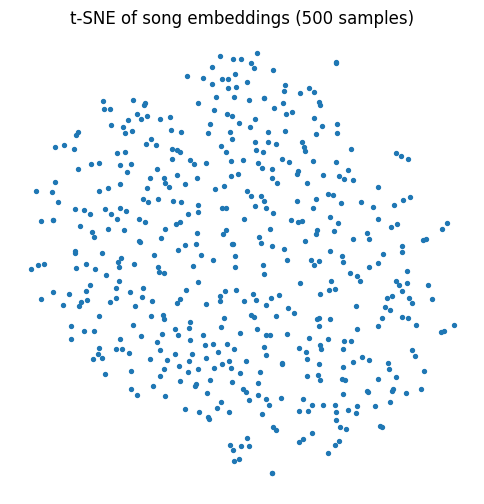

In [11]:
import numpy as np, torch, ast, pandas as pd, matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# ─── 1.  Load mean / std correctly ────────────────────────────────
stats = np.load("models/mean_std.npy", allow_pickle=True)
mean  = stats[0].astype(np.float32)    # (1,72)
std   = stats[1].astype(np.float32)

# ─── 2.  Load encoder ------------------------------------------------
enc = SongEncoder(72, 256, 128).eval()
enc.load_state_dict(torch.load("models/song_encoder.pth",
                               map_location="cpu"))

# ─── 3.  Get 500 valid rows ----------------------------------------
df = pd.read_csv("raw_vectors.csv")
df = df[df["vector"].notna()].sample(min(500, len(df)))

vecs = np.stack(df["vector"].apply(ast.literal_eval)).astype(np.float32)

# ─── 4.  Normalise and embed ---------------------------------------
normed = (vecs - mean) / std                    # broadcasting works
with torch.no_grad():
    z = enc(torch.from_numpy(normed)).numpy()   # (N,128)

# ─── 5.  Visualise with t-SNE --------------------------------------
tsne   = TSNE(n_components=2, perplexity=30, init="pca", random_state=0)
coords = tsne.fit_transform(z)

plt.figure(figsize=(6,6))
plt.scatter(coords[:,0], coords[:,1], s=8)
plt.title("t-SNE of song embeddings (500 samples)")
plt.axis("off")
plt.show()


In [14]:
from sklearn.cluster import KMeans
from umap import UMAP
import plotly.express as px
import plotly.io as pio

# --- embedding to 2-D via UMAP
coords = UMAP(n_components=2, n_neighbors=25, min_dist=0.3,
              random_state=0).fit_transform(z)

# --- unsupervised clusters
k = 8
labels = KMeans(n_clusters=k, random_state=0).fit_predict(z)

# --- dataframe for plotly
df_plot = pd.DataFrame(dict(
        x = coords[:,0],
        y = coords[:,1],
        cluster = labels,
        title = df["artist"]+" – "+df["song"]))

fig = px.scatter(df_plot, x="x", y="y", color="cluster",
                 hover_name="title", width=750, height=550,
                 color_continuous_scale="Turbo")

fig.update_traces(marker=dict(size=6, opacity=0.85,
                              line=dict(width=0)))
fig.update_layout(title="UMAP of Song Embeddings (coloured by k-means)",
                  coloraxis_showscale=False)

pio.renderers.default = "browser"
fig.show()


/opt/anaconda3/envs/ai/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [13]:
import numpy as np, pandas as pd, plotly.graph_objects as go
from sklearn.cluster import KMeans
from umap import UMAP

# ──────────────────────────────────────────────────────────────
# 1.  Fit UMAP  → 2-D coordinates
# ──────────────────────────────────────────────────────────────
coords = UMAP(n_components=2, n_neighbors=25, min_dist=0.3,
              random_state=0).fit_transform(z)

# ──────────────────────────────────────────────────────────────
# 2.  Unsupervised clustering (k-means, k = 8)
# ──────────────────────────────────────────────────────────────
k       = 8
labels  = KMeans(n_clusters=k, random_state=0).fit_predict(z)

# ──────────────────────────────────────────────────────────────
# 3.  Build DataFrame with all meta-info
# ──────────────────────────────────────────────────────────────
df_plot = pd.DataFrame({
    "x": coords[:, 0],
    "y": coords[:, 1],
    "cluster": labels,
    "title": df["artist"] + " – " + df["song"]
})

# ──────────────────────────────────────────────────────────────
# 4.  OPTION A  → pick one example from Cluster 1 and Cluster 4
# ──────────────────────────────────────────────────────────────
cluster_a, cluster_b = 1, 4          # chosen clusters
point_a = df_plot[df_plot.cluster == cluster_a].sample(1, random_state=0).iloc[0]
point_b = df_plot[df_plot.cluster == cluster_b].sample(1, random_state=0).iloc[0]

# ──────────────────────────────────────────────────────────────
# 5.  Create final figure
# ──────────────────────────────────────────────────────────────
fig = go.Figure()

# background cloud (all songs, light grey)
fig.add_trace(go.Scattergl(
    x=df_plot["x"], y=df_plot["y"],
    mode="markers", marker=dict(size=4, color="lightgrey", opacity=0.25),
    hoverinfo="skip", showlegend=False
))

# highlight Cluster 1 example
fig.add_trace(go.Scattergl(
    x=[point_a.x], y=[point_a.y],
    mode="markers+text",
    marker=dict(size=12, color="royalblue"),
    text=[point_a.title], textposition="top center",
    name=f"Cluster {cluster_a}"
))

# highlight Cluster 4 example
fig.add_trace(go.Scattergl(
    x=[point_b.x], y=[point_b.y],
    mode="markers+text",
    marker=dict(size=12, color="crimson"),
    text=[point_b.title], textposition="top center",
    name=f"Cluster {cluster_b}"
))

fig.update_layout(
    title="UMAP of Song Embeddings – Two Highlighted Examples",
    xaxis_title="", yaxis_title="",
    template="simple_white",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()


/opt/anaconda3/envs/ai/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [27]:
# ---------------------------  MAIN  ---------------------------
if __name__ == "__main__":
    CSV_PLAYLIST = "all_instagram_data.csv"      # your list of posts + song info
    MODEL_DIR    = "models"             # where .pth files live
    VECTOR_DIR   = "models"        # holds _mean_std.npy for scaling


# ─── 1.  Load mean / std correctly ────────────────────────────────
    stats = np.load("models/mean_std.npy", allow_pickle=True)
    mean  = stats[0].astype(np.float32)    # (1,72)
    std   = stats[1].astype(np.float32)

# ─── 2.  Load encoder ------------------------------------------------
    enc = SongEncoder(72, 256, 128).eval()
    enc.load_state_dict(torch.load("models/song_encoder.pth",
                               map_location="cpu"))
    # 5. run the big batch
    mass_encoder_encode_only("all_instagram_data.csv", encoder = enc)


/var/folders/zr/zy3vqzd93pz3jfh863_1bsfh0000gn/T/ipykernel_22471/4009579346.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enc.load_state_dict(torch.load("models/song_

[1] Selena Gomez, benny blanco, Gracie Abrams – Call Me When You Break Up
[2] Selena Gomez, benny blanco – Sunset Blvd
[3] Ed Sheeran – Perfect
[4] New West – Those Eyes
[5] Jungle – Ive Been In Love (feat. Channel Tres)
[6] JISOO – FLOWER
[7] JISOO – earthquake
[8] JISOO – All Eyes On Me
[9] JISOO – Your Love
[10] Yoon Jong Shin – Annie (2022 Live Version)
[11] 동요천국 – 짱구는 / 말썽쟁이짱구 (From "짱구는못말려")
• skip 동요천국 – 짱구는 / 말썽쟁이짱구 (From "짱구는못말려")  (raw vector missing)
[12] JISOO – TEARS
[13] JISOO – earthquake
• skip JISOO – earthquake  (already encoded)
[14] JISOO – Hugs & Kisses
[15] JISOO – Your Love
• skip JISOO – Your Love  (already encoded)
[16] JISOO – earthquake
• skip JISOO – earthquake  (already encoded)
[17] JISOO – TEARS
• skip JISOO – TEARS  (already encoded)
[18] JISOO – earthquake
• skip JISOO – earthquake  (already encoded)
[19] JISOO – earthquake
• skip JISOO – earthquake  (already encoded)
[20] JISOO – earthquake
• skip JISOO – earthquake  (already encoded)
[21] JISOO – eart